In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("covid_part2.ipynb")

# Final Project: COVID-19 Dataset
## Exploring COVID-19 Data through Modeling
## Due Date: Thursday, December 13th, 11:59 PM
## Collaboration Policy

Data science is a collaborative activity. While you may talk with other groups about
the project, we ask that you **write your solutions individually**. If you do
discuss the assignments with others outside of your group please **include their names** at the top
of your notebook.


## This Assignment

In this final project, we will investigate COVID-19 data over the past year. This data contains information about COVID-19 case counts, mortalities, vaccination rates, and various other metadata that can assist in modeling various aspects of COVID-19.

Through this final project, you will demonstrate your experience with:
* Data cleaning and EDA using Pandas
* Unsupervised and supervised learning techniques
* Visualization


## Goal

Model and analyze the temporal evolution of COVID-19 mortalities or cases using one unsupervised and one supervised technique of your choice. Interpret your models' results through visualizations, and draw insightful conclusions about the modeling of COVID-19 data.

Recall that we studied linear and logistic regression, decision trees, random forests as part of supervised learning (with labels) and clustering, PCA as part of unsupervised learning (without labels). You are free to use any methods that you find suitable to answer the problem at hand.

In [2]:
# Run this cell to set up your notebook
import numpy as np
from geopy import *
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import *
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from scipy.stats import pearsonr
import re

cases = pd.read_csv('data/time_series_covid19_confirmed_US.csv') # https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv
vaccinations = pd.read_csv('data/people_vaccinated_us_timeline.csv') # https://raw.githubusercontent.com/govex/COVID-19/master/data_tables/vaccine_data/us_data/time_series/people_vaccinated_us_timeline.csv
counties = pd.read_csv('data/co-est2020.csv', encoding='latin-1') # https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/counties/totals/co-est2020.csv
mask_use = pd.read_csv('data/mask-use-by-county.csv') # https://github.com/nytimes/covid-19-data/blob/master/mask-use/mask-use-by-county.csv

<br/><br/><br/>

---

<br/><br/><br/>

## Data Cleaning (Again!)

For this section, please copy over the appropriate answers from your previous notebook submission.

### Part 1: Question 1a

Impute the null values in *all* the datasets with zero values or empty strings where appropriate.

<!--
BEGIN QUESTION
name: q1a
points: 0
-->

In [3]:
cases.fillna(0, inplace = True)
vaccinations.fillna(0, inplace = True)
counties.fillna(0, inplace = True)
mask_use.fillna(0, inplace = True)

In [4]:
grader.check("q1a")

q1a results: All test cases passed!

### Part 1: Question 1d

Generate a valid FIPS code for the `counties` table.

*Hint*: Refer to [this](https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt) guide on FIPS codes.

<!--
BEGIN QUESTION
name: q1d
points: 0
-->

In [5]:
counties['FIPS'] = counties['STATE'].astype(str).str.zfill(2) + counties['COUNTY'].astype(str).str.zfill(3)        

In [6]:
grader.check("q1d")

q1d results: All test cases passed!

### Part 1: Question 1e

Merge the `counties`, `cases`, and `mask_use` tables on an appropriate primary key to generate county-wise data.

<!--
BEGIN QUESTION
name: q1e
points: 0
-->

In [7]:
cases['FIPS'] = cases['FIPS'].astype(int).astype(str).str.zfill(5)
mask_use['COUNTYFP'] = mask_use['COUNTYFP'].astype(str).str.zfill(5)

df_3 = pd.merge(cases, counties)
county_data = pd.merge(df_3, mask_use, left_on = 'FIPS', right_on = 'COUNTYFP')

In [8]:
grader.check("q1e")

q1e results: All test cases passed!

<br/><br/><br/>

---

<br/><br/><br/>

## Question 5: Guided Supervised Modeling

This section will guide you through creating a supervised learning framework that will predict the number of COVID-19 cases per capita given various COVID-19 safety protocols that have been implemented. Then, we will investigate the bias, variance, and observational noise of this framework.

Note that any answer responses without the appropriate work (i.e. code or math) will be subject to additional review and will not receive any credit.

<!-- BEGIN QUESTION -->

### Question 5a

We will use county-wise mask usage data to predict the number of COVID-19 cases on September 12th, 2021. Create a visualization that shows the pairwise correlation between each combination of column in the mask usage data and the number of COVID-19 cases.

*Hint*: You should be plotting 36 correlations.
<!--
BEGIN QUESTION
name: q5a
points: 3
manual: True
-->

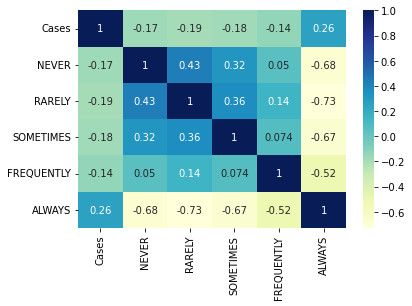

In [9]:
import seaborn as sb

mask_counties = county_data[['9/12/21','POPESTIMATE2020','COUNTYFP','NEVER','RARELY','SOMETIMES','FREQUENTLY','ALWAYS']]
mask_counties['cases_per_capita'] = mask_counties['9/12/21']/mask_counties['POPESTIMATE2020']
mask_counties = mask_counties.drop(columns = ['POPESTIMATE2020','COUNTYFP']).rename(columns = {'9/12/21':'Cases'})
mask_num_counties = mask_counties.drop(columns = ['cases_per_capita'])
dataplot = sb.heatmap(mask_num_counties.corr(), cmap="YlGnBu", annot=True)

<!-- END QUESTION -->

### Question 5b

Train a linear regression model to predict the number of COVID-19 cases using county-wise mask usage data for September 12, 2021. Evaluate your model's RMSE on a held-out validation set with 33% of the county-wise data. When possible, make sure to set `random_state = 42` when splitting your data into training and test sets.
<!--
BEGIN QUESTION
name: q5b
points: 5
-->

In [10]:
X_q5b = mask_counties[["NEVER","RARELY","SOMETIMES","FREQUENTLY","ALWAYS"]]
y_q5b = mask_counties['Cases']

from sklearn.model_selection import train_test_split
# Make sure to set random_state = 42 and test_size = 0.33!
X_q5b_train, X_q5b_test, y_q5b_train, y_q5b_test = train_test_split(X_q5b, y_q5b, test_size=0.33, random_state=42)

from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)
model.fit(X_q5b_train, y_q5b_train)

def rmse(predicted, actual):
    return np.sqrt(np.mean((actual - predicted)**2))

predicted_train = model.predict(X_q5b_train)
predicted_test = model.predict(X_q5b_test)

train_rmse_cases = rmse(predicted_train, y_q5b_train)
test_rmse_cases = rmse(predicted_test, y_q5b_test)

train_rmse_cases, test_rmse_cases

(28745.116729283855, 61671.75722098981)

In [11]:
grader.check("q5b")

q5b results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 5c

Explain potential reasons the test set RMSE is much higher as compared to the training set RMSE.
<!--
BEGIN QUESTION
name: q5c
points: 3
manual: True
-->

_A potential reason the test set RMSE is much higher compared to the training set RMSE can be due to overfitting the training dataset. The model fits too closely to the training data set making it hard to make accurate predictions on data that the model has not yet seen (testing dataset)._

<!-- END QUESTION -->

### Question 5d

Instead of predicting the number of COVID-19 cases, redo part (b) by predicting the number of cases per capita. Report the model's RMSE on the training and validation set.

Comment on the relationship between the training and test RMSE by predicting the number of cases per capita instead of the total number of cases.
<!--
BEGIN QUESTION
name: q5d
points: 3
-->

In [12]:
X_q5d = mask_counties[["NEVER","RARELY","SOMETIMES","FREQUENTLY","ALWAYS"]]
y_q5d = mask_counties['cases_per_capita']
X_q5d_train, X_q5d_test, y_q5d_train, y_q5d_test = train_test_split(X_q5d, y_q5d, test_size=0.33, random_state=42)

model2 = LinearRegression(fit_intercept=True)
model2.fit(X_q5d_train, y_q5d_train)

def rmse(predicted, actual):
    return np.sqrt(np.mean((actual - predicted)**2))

predicted_train = model2.predict(X_q5d_train)
predicted_test = model2.predict(X_q5d_test)

train_rmse_cpc = rmse(predicted_train, y_q5d_train)
test_rmse_cpc = rmse(predicted_test, y_q5d_test)

train_rmse_cpc, test_rmse_cpc

(0.03552339478226883, 0.037954861477287)

In [13]:
grader.check("q5d")

q5d results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 5e

Visualize the model outputs from part (d) by plotting the predictions $\hat{y}$ versus the observations $y$. Comment on what the plot indicates about our linear model as a comment in the code cell.

<!--
BEGIN QUESTION
name: q5e
points: 3
manual: True
-->

Text(0.5, 1.0, 'y_predicted vs y_actual of test set')

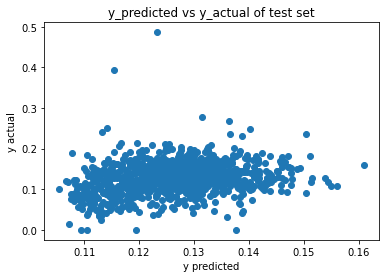

In [14]:
plt.scatter(predicted_test, y_q5d_test)
plt.xlabel('y predicted')
plt.ylabel('y actual')
plt.title('y_predicted vs y_actual of test set')
# The plot shows a very weak linear positive relationship between predictions and observations. The plot indicates that the model tends to understimate larger values. It is somewhat accurate in predicting values in the .12 and .14 range, but this model could be improved. The residuals for most of these points are quite high in proportion to the range of values for the output variable.

<!-- END QUESTION -->

### Question 5f

We will investigate the bias and variance of this improved model on the test set using the bias-variance decomposition to formalize the behaviour of our model. To generate an empirical estimate of the errors and the parameters in the bias-variance decomposition, train 1000 bootstrapped models on the training dataset from part (d).

<!--
BEGIN QUESTION
name: q5f
points: 5
-->

In [15]:
models = []

new_df = X_q5d_train.copy()
new_df['y_train'] = y_q5d_train.copy()

for i in range(1000):
    sample = new_df.sample(frac = 1, replace=True)
    X_q5f = sample[["NEVER","RARELY","SOMETIMES","FREQUENTLY","ALWAYS"]]
    y_q5f = sample['y_train']
    model = LinearRegression(fit_intercept=True)
    model.fit(X_q5f, y_q5f)
    models.append(model)

In [16]:
grader.check("q5f")

q5f results: All test cases passed!

### Question 5g

To investigate the variance in our test predictions, we sample a particular test point $(x_i, y_i)$ such that $i = 100$. In other words, we will use the 100th point in the test set from part (d), `(X_q5d_test.iloc[100], y_q5d_test.iloc[100])` as the testing point.

Generate predictions and square errors for this test point for all 1000 models, and calculate the *proportion* of the *expected* square error that is captured by the model prediction variance. In other words, we wish to estimate the following quantity:

$$
\frac{\mathrm{Var}(f_\theta(x_i))}{\mathrm{E}_\theta[(y_i - f_\theta(x_i))^2]}
$$

*Hint*: Refer to the bias-variance decomposition from lecture.
<!--
BEGIN QUESTION
name: q5g
points: 5
-->

In [17]:
#We want the sample variance of the predictions of these models and the sample mean of these models' errors.
x = np.array(X_q5d_test.iloc[100]).reshape(1, -1)
y = y_q5d_test.iloc[100]

predictions = []
errors = []
for model in models:
    prediction = model.predict(x)
    predictions.append(prediction)
    error = (y - prediction)**2
    errors.append(error)
    
var_predictions = np.var(predictions) #np.sum((predictions - np.mean(predictions))**2) / len(predictions)
sample_mean_error = np.mean(errors)
prop_var = var_predictions/sample_mean_error
prop_var

0.001229711386582408

In [18]:
grader.check("q5g")

q5g results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 5h

Using the bias-variance decomposition, comment on how much the variance of the model contributes to the error on the sample point above. We will extend this scenario to analyze the noise term in the bias-variance decomposition, specifically with regards to this COVID-19 dataset. Consider the following:

i) Assuming no observational noise (i.e. $\epsilon = 0$), what is the *magnitude* of the empirical model bias on this sample point?

ii) Clearly, there is a non-trivial amount of observational noise with COVID-19 case data simply due to how testing works and occurs. Please take a look at [this article](https://fivethirtyeight.com/features/coronavirus-case-counts-are-meaningless/) for more information. Given this infomation, explain the issues with the assumptions and result in 5h(i).

iii) Recall that we typically assume $y = g(x) + \epsilon$, where $\epsilon \sim \mathcal{N}(\mu, \sigma)$. In the theoretical setting for bias-variance, we have assumed $\mu = 0, \sigma > 0$. In this practical setting, analyze and determine how $\epsilon$ could be modeled (as a normal distribution, but you may also consider how it could be modeled as another distribution). Are there any immediate issues with the assumptions we have made in the theoretical setting where $\mu = 0, \sigma > 0$? What conditions on $\mu, \sigma$ could be more appropriate and why?

iv) Does the standard bias-variance decomposition presented in lecture hold given $\epsilon$ being normally distributed according to your answer in part (iii)? If so, please explain why. If not, explain why it does not hold and if possible, how to modify the bias-variance decomposition to make it hold (i.e. perhaps there is an additional noise term $E[\epsilon^3]$). 

*Hint*: Try to express $y = g(x) + \epsilon$ by adding and subtracting a certain quantity.

v) Intuitively, is it possible to minimize the true model bias to 0 given your $\epsilon$ formulation in part (iii)? Why or why not? Justify your answer using part (iv) if possible.

vi) Consider the infinite sample case where an oracle grants you as many samples as requested, and answer the same question in part (v). Is it possible to minimize the true model bias to 0 given your $\epsilon$ formulation in part (iii)? Conclude with an analysis of what our modeling task can approximate using $X\theta \approx y$ in the finite and infinite sample case.

<!--
BEGIN QUESTION
name: q5h
points: 24
manual: True
-->

_i.) Assuming no observational noise, the magnitude of the empirical model bias on this sample point is about 0.04. This is because model risk is equal to observation + model bias ^2 + model variance. The observation (𝜎^2) is zero and hence, the absolute value of model bias is equal to the square root of model risk minus model variance, which is approximately 0.04._

_ii.) We cannot assume that there is no observational noise as observational noise is almost always in real life situations like the COVID 19 pandemic. The article talks about how detected cases are actually really bad predictors of how many people are actually infected, underestimating “from a multiple of two times to 100 times.” This can be due to people not getting tested, or the fact that 30% of cases are asymptomatic._

_iii.) Currently, 𝜇 is assumed to be 0 because it was assumed that noise would cancel out as we expected equal chances of overestimation and underestimation. We expected when ε is positive and when the ε is negative would cancel out. However, from the previous part of the question and the article, we see that there tends to be underestimation, meaning that there is more negative ε so 𝜇 is much more likely to be negative rather than 0, and g(x) is much higher._

_iv.) According to our answer in part (iii), the standard bias-variance decomposition presented in lecture hold given 𝜖 being normally distributed does not hold. This is because 𝜖 is no longer normally distributed around 0. To make it hold, we can modify the bias-variance decomposition (see math below).
Bias variance decomposition defines that the model risk is equal to the observation variance + model variance + model bias squared. [E(f(x)-(g(x)+μ))]^2 
Math work:
y = g(x) + μ + 𝜖 - μ
g'(x) = g(x) + μ
𝜖' = 𝜖 - μ
y' = g'(x) + 𝜖'_

_v.) It is not possible to minimize the true model bias to 0 given our 𝜖 formulation in part (iii). This is because 𝜇 is shifted by an unknown value._

_vi.) In the infinite case, it is also not possible to minimize the true model bias to 0 given our 𝜖 formulation in part (iii) because regardless of how many samples we take, we still cannot find out what 𝜇 is and hence, we cannot minimize the true model bias to 0._

<!-- END QUESTION -->

### Question 5i

Using the bias-variance decomposition for each test point, calculate the average variance and average test mean-square error across the entire test set from part (d). In other words, estimate the following quantities:

$$
\frac{1}{n} \sum_i \mathrm{Var}(f_\theta(x_i))
$$

and

$$
\frac{1}{n} \sum_i \mathrm{E}_\theta[(y_i - f_\theta(x_i))^2]
$$

<!--
BEGIN QUESTION
name: q5i
points: 5
manual: False
-->

In [19]:
var_predictions = []
sample_mean_errors = []

for i in range(len(X_q5d_test)):
    x = np.array(X_q5d_test.iloc[i]).reshape(1, -1)
    y = y_q5d_test.iloc[i]
    predictions = []
    errors = []
    for model in models:
        prediction = model.predict(x)
        predictions.append(prediction)
        error = (y - prediction)**2
        errors.append(error)
    var_predictions.append(np.var(predictions))
    sample_mean_errors.append(np.mean(errors))

avg_var, avg_mse = np.mean(var_predictions), np.mean(sample_mean_errors)

avg_var, avg_mse

(3.884310268368218e-06, 0.0014443147966022507)

In [20]:
grader.check("q5i")

q5i results: All test cases passed!

<!-- BEGIN QUESTION -->

## Question 5j

Propose a solution to reducing the mean square error using the insights gained from the bias-variance decomposition above. What are the values of the quantities that have we estimated and what can be concluded about the remaining quantities? Please show all work that informs your analysis.

Assume that the standard bias-variance decomposition used in lecture can be applied here.
<!--
BEGIN QUESTION
name: q5j
points: 5
manual: True
-->

_Mean square error can be in the form of model bias, model variance, and irreducible observational variance. Of these three, we could attempt to reduce model bias as bias contributes more error than variance. With the above parts and code, we have estimated the mean square error along with the variance of the model. Because variance is much smaller compared to the mean square error, noise and bias must be much bigger. While we are unable to reduce noise, we can try to reduce bias. A few possible ways to reduce model bias is to increase model complexity (while ensuring that we don’t overfit) and consulting with domain experts to determine which of the models make sense._

<!-- END QUESTION -->



<br/><br/><br/>

---

<br/><br/><br/>

## Question 6: Open Supervised Modeling

We wish to extend our modeling framework from Question 5 to make it more accurate; in other words, we wish to predict $f(x)$, a supervised learning output, based on past and current quantities. 

This section will serve as a rough guide on creating an autoregressive modeling framework for predicting a COVID-19 quantity of your choice (i.e. deaths, cases, vaccinations).

Note that if you do not wish to pursue time-based modeling of COVID-19, you may skip parts (d), (e), and (f). That being said, you are strongly encouraged to incorporate time-based modeling into your open-ended modeling design since it constitutes a large component of the provided datasets.

We will ***not*** grade these below questions individually (i.e. there are no points explicitly assigned to questions 6(a) to 6(f)); they are simply guiding questions and will be graded as part of the final project report. You should make sure to answer all of the questions (that are applicable to your open-ended modeling) in some form in the report.

### Open-Ended EDA (CLOBBER):

_Improved Hypothesis: Partaking in more COVID-19 precautions (higher mask usage, higher vaccinations per capita, more social distancing) is correlated to less COVID-19 cases per capita for each county in the U.S._

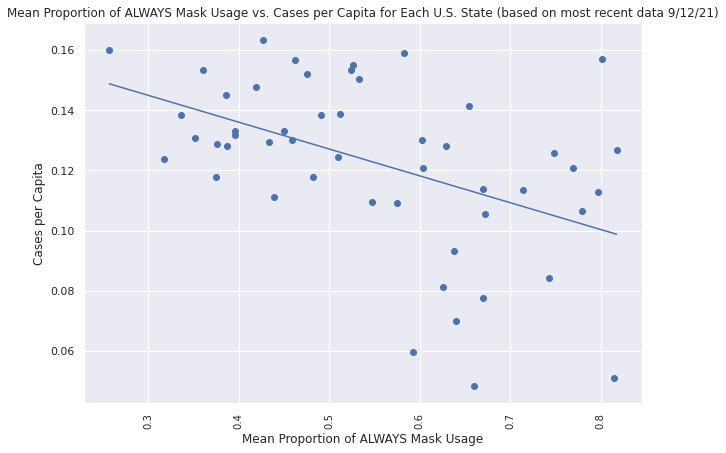

In [36]:
case_num = pd.DataFrame(cases.groupby('Province_State')['9/12/21'].sum())
population = pd.DataFrame(counties[counties['STNAME'] != counties['CTYNAME']].groupby('STNAME')['POPESTIMATE2020'].sum())

newer = pd.merge(case_num, population, left_index=True, right_index=True)
newer['cases per capita'] = newer['9/12/21'] / newer['POPESTIMATE2020']
new_vaccine = vaccinations[vaccinations['Date'] == '2021-09-12'].set_index('Province_State')
newer_2 = pd.merge(newer, new_vaccine, left_index = True, right_index = True).reset_index()

mask_use_2 = mask_use.copy()
mask_use_2['FIPS'] = pd.to_numeric(mask_use_2.COUNTYFP.str[:2])
mask_state = mask_use_2.groupby('FIPS').agg(np.mean).reset_index() # mean for each state prop of mask usage

almost = pd.merge(newer_2, mask_state, left_on = 'FIPS', right_on = 'FIPS')
almost['prop_fully_vaccinated'] = almost['People_Fully_Vaccinated'] / almost['POPESTIMATE2020']
almost['prop_partially_vaccinated'] = almost['People_Partially_Vaccinated'] / almost['POPESTIMATE2020']
almost = almost.drop(columns = ['9/12/21', 'POPESTIMATE2020', 'FIPS', 'Country_Region','Date','Lat','Long_','People_Fully_Vaccinated','People_Partially_Vaccinated', 'Combined_Key']).rename(columns = {'index':'Location'}).set_index('Location')

highest_always = almost.sort_values(by = "ALWAYS", ascending = True)
highest_always
plt.figure(figsize=(10,7))
plt.xlabel('Mean Proportion of ALWAYS Mask Usage')
plt.xticks(fontsize=10, rotation = 90)

plt.ylabel('Cases per Capita')
plt.title('Mean Proportion of ALWAYS Mask Usage vs. Cases per Capita for Each U.S. State (based on most recent data 9/12/21)')

x=highest_always['ALWAYS']
y=highest_always['cases per capita']
plt.scatter(x, y)

#least squares polynomial fit on top of scatter plot
m, b = np.polyfit(x, y, 1)

plt.plot(x, m*x + b)

_The data used to create the above visualization is a joined dataset from the cases, counties, and mask_use dataframes. Each row in the dataset represents a particular state in the U.S. There are two features corresponding to each state: cases per capita and the mean proportion of the population whose mask usage is maximum (‘ALWAYS’) within each state. Each state’s population estimate in 2020 (‘POPESTIMATE2020’) was used to derive these features. This data is from 9/12/20, the most recent count of total cases for each U.S. state.
This scatter plot analyzes the mean proportion of each state who wears masks at the maximum “Always” frequency (that was aggregated by taking the mean of the proportions for all counties in a particular state) and the Covid-19 cases per capita based on September 12, 2021 data. This visualization indicates that states with a higher mean proportion of “Always” mask usage tend to be correlated with having fewer cases per capita as we can notice a downward trend in the data. This conclusion supports our hypothesis, which initially stated that states participating in more Covid-19 precautions (i.e. mask usage) are correlated with fewer Covid-19 cases compared to states who don’t in the United States.
In this visualization, a higher mean proportion of the Always mask usage seems to correlate to less COVID cases per capita for each state. Therefore, this would provide a justification for our hypothesis, and we are intrigued to determine whether including social distancing as a feature would also have an effect on improving/reducing the correlation between COVID precautions and the number of cases for each county. Specifically, how does social mobility in various areas (e.g. workplaces, residential, transit stations) correlate to the number of COVID-19 cases per capita for each county in the U.S.? In other words, does reducing the frequency of close contact between people contribute to minimizing the cases per capita?_

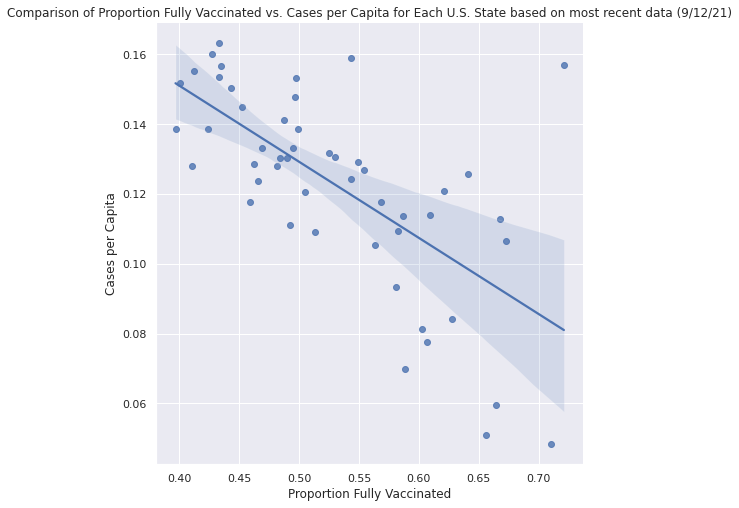

In [37]:
#recent data 9/12/21
vaccine_df = almost[['cases per capita','prop_fully_vaccinated']]
vaccine_df
sns.set(font_scale=1)
sns.lmplot(x = 'prop_fully_vaccinated', y = 'cases per capita', data = vaccine_df, fit_reg = True, height = 7);
sns.set(font_scale=1)
plt.title('Comparison of Proportion Fully Vaccinated vs. Cases per Capita for Each U.S. State based on most recent data (9/12/21)')
plt.xlabel('Proportion Fully Vaccinated')
plt.ylabel('Cases per Capita');

_The data set used to create this visualization is a joined dataset from the cases, counties, and mask_use dataframes in order to create new columns labeled ‘cases per capita’ and prop_fully_vaccinated’. Each row in the dataset represents a state in the U.S. There are two features corresponding to each state: cases per capita and the proportion of the population within each state that is fully vaccinated. The population used to derive these features was based on ‘POPESTIMATE2020’ (each state’s population estimate in 2020). In addition, this data is only using data from 9/12/20 which represents the most recent count of total cases and vaccinations for each U.S. state. 
This scatterplot shows a moderate negative correlation between the proportion fully vaccinated and cases per capita for each state. This means that as the proportion fully vaccinated increases in states, the cases per capita overall decreases. As the proportion fully vaccinated decreases, the cases per capita overall increases. In relation to our hypothesis, this visualization proves that participating in COVID-19 precautions like getting vaccinated is correlated to less cases per capita for each state. Therefore, there is a likelihood that social distancing is also correlated to less COVID cases per capita and possibly lower COVID cases overall._


### Modeling

- We will be doing multivariate modeling and using a Random Forest Regression model to predict cases per capita for each state based on COVID precautions. 
To do this, we will use the data already provided in the data frames “vaccinations,” “cases,” “mask_use,” and “counties.” We will also look for external data about social distancing in each county and vaccination rate for each county. 
- We will introduce a new dataset through Google’s COVID-19 Community Mobile Reports. For each state, there is information about ‘retail & recreation’, ‘grocery & pharmacy’, ‘parks’, ‘transit stations’, ‘workplaces’, and ‘residential’. The data is organized temporally in which they measure the daily increase or decrease in each of the categories outlined in comparison to a baseline of 0% for each state. We will gather the median for each of these categories amongst all days recorded starting from January 23, 2020 to September 12, 2021. In addition we will get data about the value of fully vaccinated populations in each county from CDC. 
- We will predict total number of cases per capita for each county based on the most recent data (up until 9/12/21) by using a Random Forest Regression model based on 12 features: proportion of mask wearing (ALWAYS, NEVER, SOMETIMES, RARELY, FREQUENTLY) population, proportion of fully vaccinated population, percent of social mobility for each category for each state. We will use a train/test split of 80/20%. We will improve this model through cross validation and regularization which will in particular, help identify the best features of social mobility to use.
- We will visualize the accuracy of our model by calculating the RMSE and visualizing predictions vs. the actual number of total cases in a scatterplot. A scatterplot with a high correlation will mean that our hypothesis is proven to be true, while a low correlation will conclude that our hypothesis is not justifiable as the hypothesized COVID-19 precautions would not be highly efficient at predicting COVID cases per capita for each county. We can also visualize the accuracy of our hypothesis by creating a scatterplot between each feature and cases per capita to see if that particular COVID precaution has a postive or negative correlation with cases per capita. If lower cases per capita are correlated with more people doing a COVID precaution, then our hypothesis can be proven to be true.


<!-- BEGIN QUESTION -->

### Question 6a

Train a baseline model where $f$ is the model described in Question 0a and $x$ is a quantity of *your* choice. Note that you may used *any* supervised learning approach we have studied; you are not limited to a linear model.

<!--
BEGIN QUESTION
name: q6a
points: 0
manual: True
-->

Hypothesis: Partaking in more COVID-19 precautions (higher mask usage, higher vaccinations per capita, more social distancing) is correlated to less COVID-19 cases per capita for each county in the U.S.

We will predict total number of cases per capita for each county based on the most recent data (up until 9/12/21) by using a Random Forest Regression model based on 12 features: proportion of mask wearing (ALWAYS, NEVER, SOMETIMES, RARELY, FREQUENTLY) population, proportion of fully vaccinated population, percent of social mobility for each category for each state. We will use a train/test split of 80/20%. We will improve this model through cross validation and regularization which will in particular, help identify the best features of social mobility to use.

- Problem: We can visualize the accuracy of our hypothesis by creating a scatterplot between each feature listed above and cases per capita to see if that particular COVID precaution has a postive or negative correlation with cases per capita. If lower cases per capita are correlated with more people doing a COVID precaution, then our hypothesis can be proven to be true. We can confirm this hypothesis with existing datasets. 

- Answer: Plots labeled 1 - 4 below prove this hypothesis to be true. 

PLOT 1 - There is a moderately weak negative linear correlation between the proportion fully vaccinated and the cases per capita in each county for data updated on 9/12/21. This shows that a higher proportion of a fully vaccinated population is correlated to less cases per capita for each county. 

PLOT 2 - There is a moderately weak positive linear correlation between the proportion of NEVER mask usage and the cases per capita in each county for data updated on 9/12/21. This shows that a higher proportion of never wearing masks is correlated to higher cases per capita for each county.

PLOT 3 - There is a moderate negative linear correlation between the proportion of ALWAYS mask usage and the cases per capita in each county for data updated on 9/12/21. This shows that a higher proportion of always wearing masks is correlated to lower cases per capita for each county.

PLOT 4 - There is a moderately weak positive linear correlation between the median social mobility score for workplaces and the cases per capita in each county for data updated on 9/12/21. This shows that a higher social mobility score of workplaces (more people are going to work) is correlated to higher cases per capita for each county.

Note: many cells are commented out for using external datasets

In [11]:
# vaccine_counties = pd.read_csv('vaccines_counties.csv') #importing external dataset
# vaccine_c = vaccine_counties[vaccine_counties['FIPS'] != 'UNK']
# vaccine_c['FIPS'] = vaccine_c['FIPS'].astype(int)
# vaccine_c = vaccine_c[['FIPS', 'Series_Complete_Yes']]

In [12]:
placer = county_data[['FIPS','9/12/21','POPESTIMATE2020','COUNTYFP','NEVER','RARELY','SOMETIMES','FREQUENTLY','ALWAYS']]
placer['cases_per_capita'] = placer['9/12/21']/placer['POPESTIMATE2020']
placer['FIPS'] = placer['FIPS'].astype(int)
placer = placer.merge(vaccine_c, left_on = 'FIPS', right_on = 'FIPS')
placer

,FIPS,9/12/21,POPESTIMATE2020,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,cases_per_capita,Series_Complete_Yes
0,1001,9287,56145,01001,0.053,0.074,0.134,0.295,0.444,0.165411,16609
1,1003,34950,229287,01003,0.083,0.059,0.098,0.323,0.436,0.152429,84223
2,1005,3295,24589,01005,0.067,0.121,0.120,0.201,0.491,0.134003,7659
3,1007,3795,22136,01007,0.020,0.034,0.096,0.278,0.572,0.171440,5910
4,1009,9176,57879,01009,0.053,0.114,0.180,0.194,0.459,0.158538,12537
...,...,...,...,...,...,...,...,...,...,...,...
3136,56037,6111,42673,56037,0.061,0.295,0.230,0.146,0.268,0.143205,14627
3137,56039,4611,23497,56039,0.095,0.157,0.160,0.247,0.340,0.196238,18219
3138,56041,3204,20215,56041,0.098,0.278,0.154,0.207,0.264,0.158496,7405
3139,56043,1120,7760,56043,0.204,0.155,0.069,0.285,0.287,0.144330,2610


In [13]:
#placer[placer['Series_Complete_Yes']/placer['POPESTIMATE2020'] >= 1] strange outlier, POPESTIMATE2020 might be an underestimate for this county

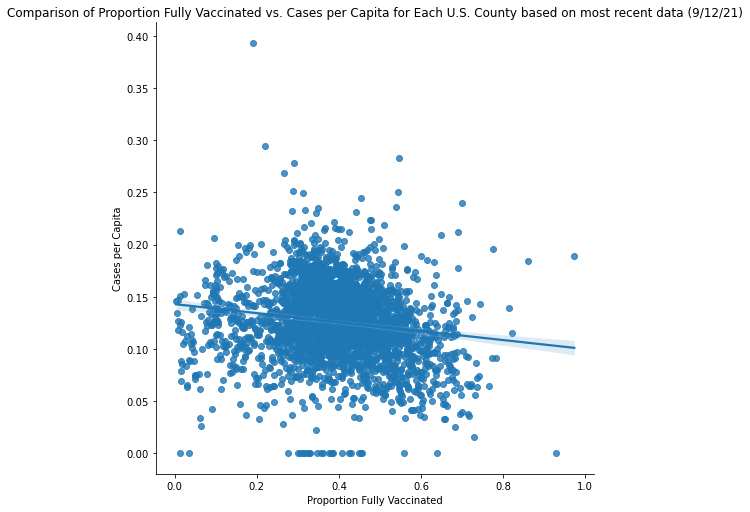

In [14]:
# pl = placer[placer['Series_Complete_Yes']/placer['POPESTIMATE2020'] <= 1] # making sure all proportions are less than 1
# pl = pl[pl['Series_Complete_Yes'] > 0] # removing outliers (no reported data on vaccinations)
# pl['vac_prop_cy'] = pl['Series_Complete_Yes']/pl['POPESTIMATE2020']

# sns.lmplot(x = 'vac_prop_cy', y = 'cases_per_capita', data = pl, fit_reg = True, height = 7);
# sns.set(font_scale=1)
# plt.title('Comparison of Proportion Fully Vaccinated vs. Cases per Capita for Each U.S. County based on most recent data (9/12/21)')
# plt.xlabel('Proportion Fully Vaccinated')
# plt.ylabel('Cases per Capita');

_PLOT 1 - There is a moderately weak negative linear correlation between the proportion fully vaccinated and the cases per capita in each county for data updated on 9/12/21. This shows that a higher proportion of a fully vaccinated population is correlated to less cases per capita for each county._

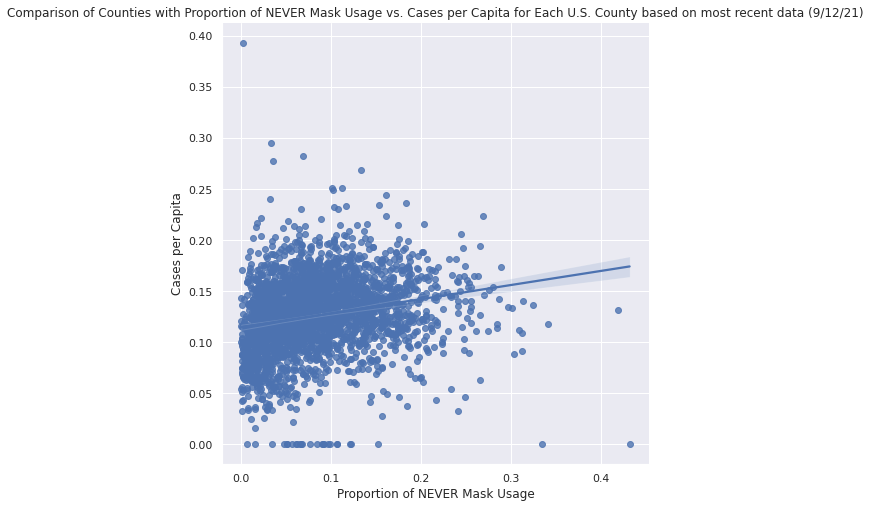

In [15]:
sns.lmplot(x = 'NEVER', y = 'cases_per_capita', data = pl, fit_reg = True, height = 7);
sns.set(font_scale=1)
plt.title('Comparison of Counties with Proportion of NEVER Mask Usage vs. Cases per Capita for Each U.S. County based on most recent data (9/12/21)')
plt.xlabel('Proportion of NEVER Mask Usage')
plt.ylabel('Cases per Capita');

_PLOT 2 - There is a moderately weak positive linear correlation between the proportion of NEVER mask usage and the cases per capita in each county for data updated on 9/12/21. This shows that a higher proportion of never wearing masks is correlated to higher cases per capita for each county._

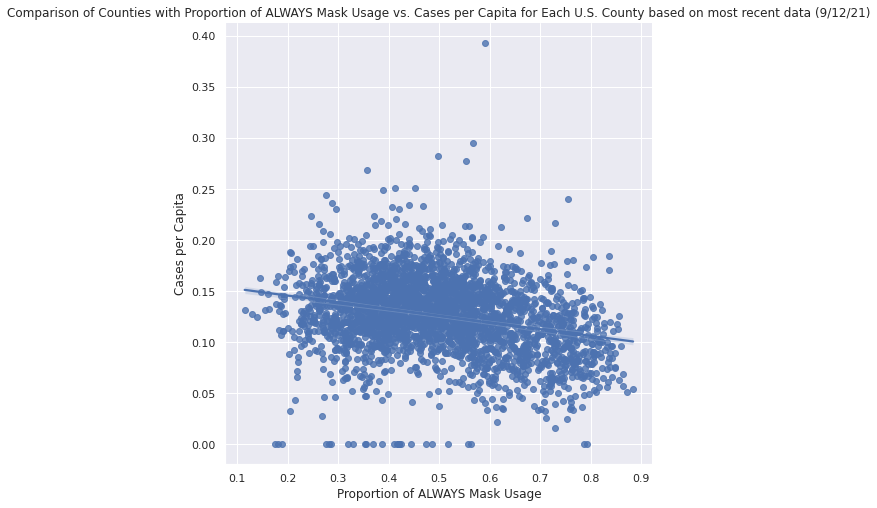

In [23]:
sns.lmplot(x = 'ALWAYS', y = 'cases_per_capita', data = pl, fit_reg = True, height = 7);
sns.set(font_scale=1)
plt.title('Comparison of Counties with Proportion of ALWAYS Mask Usage vs. Cases per Capita for Each U.S. County based on most recent data (9/12/21)')
plt.xlabel('Proportion of ALWAYS Mask Usage')
plt.ylabel('Cases per Capita');

_PLOT 3 - There is a moderate negative linear correlation between the proportion of ALWAYS mask usage and the cases per capita in each county for data updated on 9/12/21. This shows that a higher proportion of always wearing masks is correlated to lower cases per capita for each county._

_The three plots above showing linear relationships between the proportion of fully vaccinated, NEVER mask usage, and ALWAYS mask usage with cases per capita are example of ways to prove our improved hypothesis: Partaking in more COVID-19 precautions (higher mask usage, higher vaccinations per capita, more social distancing) is correlated to less COVID-19 cases per capita for each county in the U.S._

### TRIAL RUN: Testing a Linear Regression model with only mask usage and vaccination proportion for all counties

In [15]:
from sklearn.ensemble import RandomForestRegressor

placer = pl
X = placer[["NEVER","SOMETIMES","FREQUENTLY","ALWAYS","RARELY",'vac_prop_cy']] # "Series_Complete_Yes"
y = placer['cases_per_capita']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

baseline = LinearRegression(fit_intercept = True)
baseline.fit(X, y)

def rmse(predicted, actual):
    return np.sqrt(np.mean((actual - predicted)**2))

train_rmse = rmse(baseline.predict(X_train), y_train)
test_rmse = rmse(baseline.predict(X_test), y_test)

train_rmse, test_rmse

(0.03529878085577151, 0.03434430790369493)

Text(0.5, 1.0, 'Cases per Capita predicted vs Cases per Capita actual for LR Model 1')

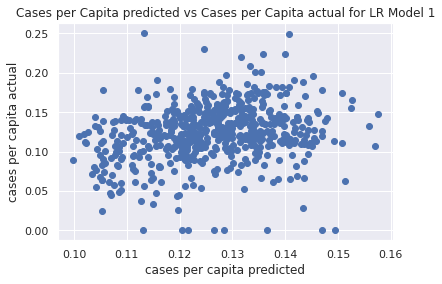

In [28]:
plt.scatter(baseline.predict(X_test), y_test)
plt.xlabel('cases per capita predicted')
plt.ylabel('cases per capita actual')
plt.title('Cases per Capita predicted vs Cases per Capita actual for LR Model 1')

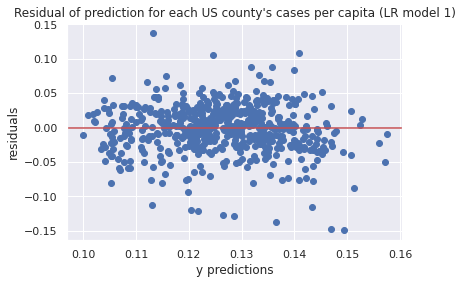

In [29]:
predictions = baseline.predict(X_test)
plt.scatter(predictions, y_test - predictions)
plt.ylabel('residuals')
plt.xlabel('y predictions')
plt.title("Residual of prediction for each US county's cases per capita (LR model 1)")
plt.axhline(y = 0, color='r');

In [30]:
baseline.score(X_test, y_test)

0.04894778501866581

In [31]:
from sklearn.ensemble import RandomForestRegressor

placer = pl
X = placer[["NEVER","RARELY","SOMETIMES","FREQUENTLY","ALWAYS",'vac_prop_cy']] # "Series_Complete_Yes"
y = placer['cases_per_capita']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

#baseline = LinearRegression(fit_intercept = True)
baseline2 = RandomForestRegressor()
baseline2.fit(X, y)

def rmse(predicted, actual):
    return np.sqrt(np.mean((actual - predicted)**2))

train_rmse = rmse(baseline2.predict(X_train), y_train)
test_rmse = rmse(baseline2.predict(X_test), y_test)

train_rmse, test_rmse

(0.012904928854986671, 0.012098348396627307)

Text(0.5, 1.0, 'Cases per Capita predicted vs Cases per Capita actual for RF Model 1')

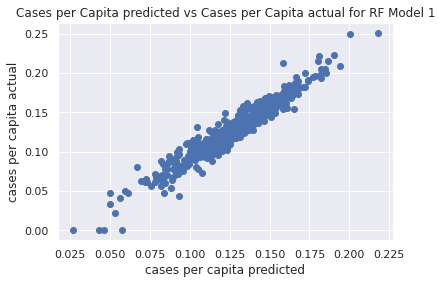

In [32]:
plt.scatter(baseline2.predict(X_test), y_test)
plt.xlabel('cases per capita predicted')
plt.ylabel('cases per capita actual')
plt.title('Cases per Capita predicted vs Cases per Capita actual for RF Model 1')

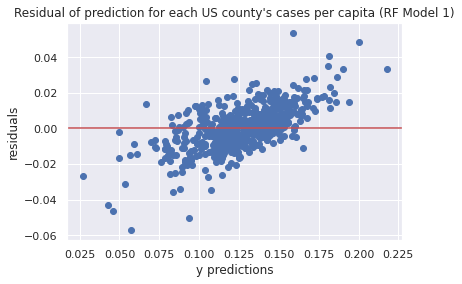

In [33]:
predictions = baseline2.predict(X_test)
plt.scatter(predictions, y_test - predictions)
plt.ylabel('residuals')
plt.xlabel('y predictions')
plt.title("Residual of prediction for each US county's cases per capita (RF Model 1)")
plt.axhline(y = 0, color='r');

In [34]:
baseline2.score(X_test, y_test)

0.8770376463478277

In [35]:
score_test = baseline2.score(X_test, y_test)
score_train = baseline2.score(X_train, y_train)
print("Train Score is :", score_train)
print("Test Score is :", score_test)

Train Score is : 0.8816260906518204
Test Score is : 0.8770376463478277


### IMPORTING A NEW DATASET FOR SOCIAL MOBILITY SCORES (A COVID-19 precaution)

In [16]:
vaccines_counties = pd.read_csv('vaccines_counties.csv')

In [17]:
sm = pd.read_csv('social_mobility (1).csv') #new external dataset
sm['sub_region_2'] = sm['sub_region_2'].str.replace(' County', '')
newer = county_data.merge(sm, left_on = ['Province_State','Admin2'], right_on = ['sub_region_1','sub_region_2'])
#newer.isnull().sum().sort_values()
newer['FIPS'] = newer['FIPS'].astype(int)
newer = newer[['FIPS', 'retail_and_recreation_percent_change_from_baseline','grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline']] # too many null in 'residential_percent_change_from_baseline' that it has no median for majority of the counties so excluded in this baseline model
#newer = newer.fillna(0)
final = newer.merge(placer, left_on = 'FIPS', right_on = 'FIPS')
final['prop_vac'] = final['Series_Complete_Yes']/final['POPESTIMATE2020']
final = final.drop(columns = ['9/12/21','POPESTIMATE2020', 'COUNTYFP'])

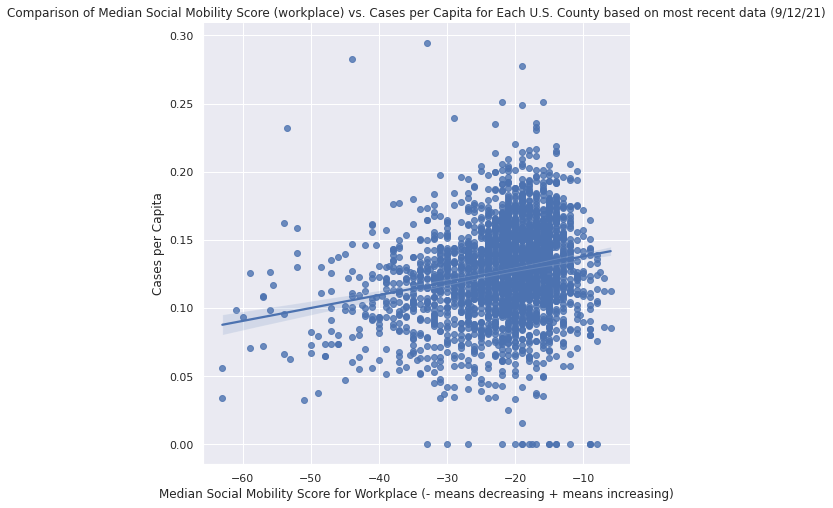

In [21]:
# workplaces has the least number of null values
sns.lmplot(x = 'workplaces_percent_change_from_baseline', y = 'cases_per_capita', data = final, fit_reg = True, height = 7);
sns.set(font_scale=1)
plt.title('Comparison of Median Social Mobility Score (workplace) vs. Cases per Capita for Each U.S. County based on most recent data (9/12/21)')
plt.xlabel('Median Social Mobility Score for Workplace (- means decreasing + means increasing)')
plt.ylabel('Cases per Capita');

_PLOT 4 - There is a moderately weak positive linear correlation between the median social mobility score for workplaces and the cases per capita in each county for data updated on 9/12/21. This shows that a higher social mobility score of workplaces (more people are going to work) is correlated to higher cases per capita for each county. This plot above is another example of how to prove our improved hypothesis: Partaking in more COVID-19 precautions (higher mask usage, higher vaccinations per capita, more social distancing) is correlated to less COVID-19 cases per capita for each county in the U.S. This plot shows that more social distancing (in the workplace) is correlated to less cases per capita._

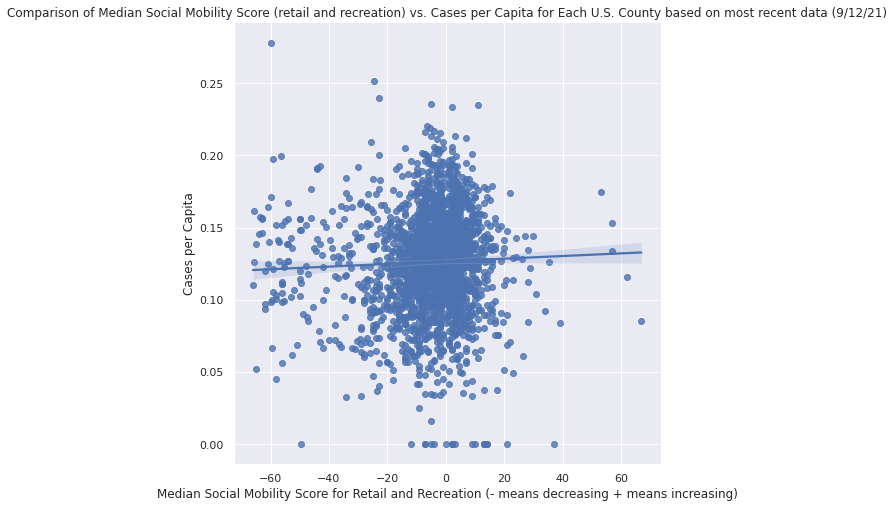

In [22]:
sns.lmplot(x = 'retail_and_recreation_percent_change_from_baseline', y = 'cases_per_capita', data = final, fit_reg = True, height = 7);
sns.set(font_scale=1)
plt.title('Comparison of Median Social Mobility Score (retail and recreation) vs. Cases per Capita for Each U.S. County based on most recent data (9/12/21)')
plt.xlabel('Median Social Mobility Score for Retail and Recreation (- means decreasing + means increasing)')
plt.ylabel('Cases per Capita');

_PLOT 5 - There is little to no linear correlation between the median social mobility score for retail and recreation and the cases per capita in each county for data updated on 9/12/21. This feature's lack of a linear relationship with the output (cases per capita) will be explored later. This introduces the idea that not all of our features that we plan to use in our model will have a linear relationship with cases per capita although most of them do._

### BASELINE MODELS

_In order to determine the best baseline model, we trained our data on a Multiple Linear Regression model and Random Forest Regression model._

_The inputs for both of the baseline models were:_
- ‘prop_vac’ - proportion of fully vaccinated population in each county updated on 09/12/21 based on POPESTIMATE2020 and external dataset by CDC 
- ‘retail_and_recreation_percent_change_from_baseline’ - median value for social mobility in the geographic category: retail and recreation over the span of time from 01/23/21 to 09/12/21 (based on Google Community Mobility Reports)
- ‘grocery_and_pharmacy_percent_change_from_baseline' - median value for social mobility in the geographic category: grocery and pharmacy over the span of time from 01/23/21 to 09/12/21 (based on Google Community Mobility Reports)
- 'parks_percent_change_from_baseline' - median value for social mobility in the geographic category: parks over the span of time from 01/23/21 to 09/12/21 (based on Google Community Mobility Reports)
- 'transit_stations_percent_change_from_baseline' - median value for social mobility in the geographic category: transit stations over the span of time from 01/23/21 to 09/12/21 (based on Google Community Mobility Reports)
- 'workplaces_percent_change_from_baseline' - median value for social mobility in the geographic category: workplaces over the span of time from 01/23/21 to 09/12/21 (based on Google Community Mobility Reports)
- "NEVER" - NEVER mask usage proportion from mask_use data for each county
- "RARELY" - RARELY mask usage proportion from mask_use data for each county
- "SOMETIMES" - SOMETIMES mask usage proportion from mask_use data for each county
- "FREQUENTLY" - FREQUENTLY mask usage proportion from mask_use data for each county
- "ALWAYS" - ALWAYS mask usage proportion from mask_use data for each county


_Additional Notes on Inputs:_
- We used the median for our six categories of social mobility scores in order to get an overall representation of each county’s social mobility score over the time frame of when cases began to be reported (1/23/2021 to 9/12/21). Median was preferred over mean, because of having both positive and negative numbers present in each category. 
- We excluded 'residential_percent_change_from_baseline' in the baseline model, because there were too many null values in the original dataset, and this meant the median was not calculable for most counties. 
- Any null values in the other social mobility categories were replaced with 0 to signify no movement from the base of 0% change in social mobility.


Outputs: 
- ‘cases_per_capita’ determined by taking the total number of cases recorded by 09/12/21 and dividing it by POPESTIMATE2020 for each county. 

_Sources Explanation:_

Deriving number of fully vaccinated people for each county: https://data.cdc.gov/Vaccinations/COVID-19-Vaccinations-in-the-United-States-County/8xkx-amqh
- For baseline model - We took data from 09/12/2021 which was the total number of fully vaccinated people ('vaccines_counties.csv')
- For improvement 1 of the model - We first gathered data only from 04/12/2021 to 09/12/2021 in a Google Colab notebook and then imported a new csv file to the project (allows for faster processing of the code in this notebook) ('vaccines_counties_time.csv')

Deriving social mobility scores (all 6 categories): https://www.kaggle.com/bigquery/covid19-google-mobility 
- For baseline model - Data was collected from '2020-01-23 to 2021-09-12' in order to match with cases_per_capita data in provided cases and county dataset. We also calculated median of each sub category of social mobility taken from these dates as a representation of the county's social mobility overall in a Google Colab notebook and then transferred it to a new csv file ('social_mobility (1)')
- For time-based model - We took data from 07/02/2021 to 07/14/2021 in Google Colab and then imported the new csv file to this project (allows for faster processing since this a very large dataset) ('social_mobility_july')

Link to Google Colab notebook: https://colab.research.google.com/drive/1mU2fpfqfxZiIKYHYAFRqfXw8IOxewjrN?usp=sharing

In [19]:
# final = final.fillna(0)
# X = final[["prop_vac", 'retail_and_recreation_percent_change_from_baseline',
#             'grocery_and_pharmacy_percent_change_from_baseline','parks_percent_change_from_baseline', 
#             'transit_stations_percent_change_from_baseline','workplaces_percent_change_from_baseline',
#           "NEVER","RARELY","SOMETIMES","FREQUENTLY","ALWAYS"]]
# y = final['cases_per_capita']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# baseline_new = LinearRegression(fit_intercept=True)
# baseline_new.fit(X, y)

# def rmse(predicted, actual):
#     return np.sqrt(np.mean((actual - predicted)**2))

# train_rmse = rmse(baseline_new.predict(X_train), y_train)
# test_rmse = rmse(baseline_new.predict(X_test), y_test)

# train_rmse, test_rmse

(0.03401421801316921, 0.03490176743825563)

_We are training a Multiple Linear Regression model first, because we notice a linear relationship between mask usage, some social mobility scores and cases per capita for each county. This linear relationship can be seen in Plots 1-4._

Text(0.5, 1.0, 'Cases per Capita predicted vs Cases per Capita actual for LR Model Baseline')

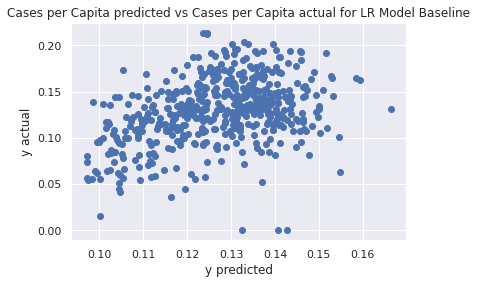

In [25]:
plt.scatter(baseline_new.predict(X_test), y_test)
plt.xlabel('y predicted')
plt.ylabel('y actual')
plt.title('Cases per Capita predicted vs Cases per Capita actual for LR Model Baseline')

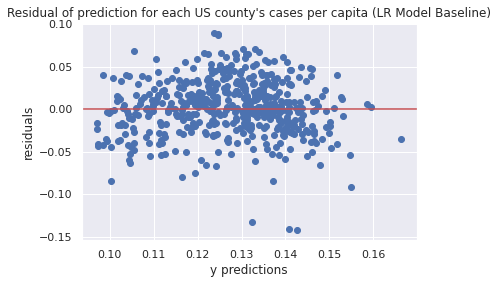

In [26]:
predictions = baseline_new.predict(X_test)
plt.scatter(predictions, y_test - predictions)
plt.ylabel('residuals')
plt.xlabel('y predictions')
plt.title("Residual of prediction for each US county's cases per capita (LR Model Baseline)")
plt.axhline(y = 0, color='r');

In [44]:
baseline_new.score(X_test, y_test)

0.13432259576407968

In [46]:
score_test = baseline_new.score(X_test, y_test)
score_train = baseline_new.score(X_train, y_train)
print("Train Score is :", score_train)
print("Test Score is :", score_test)

Train Score is : 0.14140134629689272
Test Score is : 0.13432259576407968


_Despite having many features that have a linear relationship with the output (cases per capita), there are some features that do not have as strong or any linear relationship at all with the target variable like 'retail_and_recreation_percent_change_from_baseline'. Since not all features have a linear dependency, Random Forest Regression (RFR) might be better at representing the complex dependencies between the features. RFR can also represent large datasets well, handle missing values like the few in the social mobility categories, and it is more efficient at predicting amongst complicated relationships and outliers._

In [20]:
# from sklearn.ensemble import RandomForestRegressor

# X = final[["prop_vac", 'retail_and_recreation_percent_change_from_baseline',
#             'grocery_and_pharmacy_percent_change_from_baseline','parks_percent_change_from_baseline', 
#             'transit_stations_percent_change_from_baseline','workplaces_percent_change_from_baseline',
#             "NEVER","ALWAYS","RARELY","SOMETIMES","FREQUENTLY"]]
# y = final['cases_per_capita']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# baseline_better = RandomForestRegressor()
# baseline_better.fit(X, y)

# def rmse(predicted, actual):
#     return np.sqrt(np.mean((actual - predicted)**2))

# train_rmse = rmse(baseline_better.predict(X_train), y_train)
# test_rmse = rmse(baseline_better.predict(X_test), y_test)

# train_rmse, test_rmse

(0.012273640158940823, 0.010944068945704943)

Text(0.5, 1.0, 'Cases per Capita predicted vs Cases per Capita actual for RF Model Baseline')

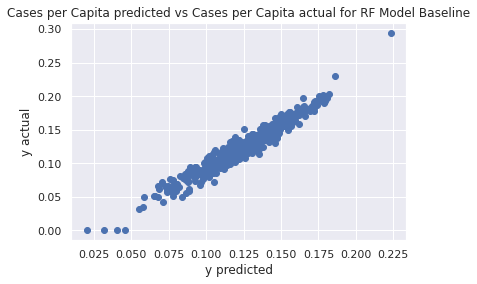

In [32]:
plt.scatter(baseline_better.predict(X_test), y_test)
plt.xlabel('y predicted')
plt.ylabel('y actual')
plt.title('Cases per Capita predicted vs Cases per Capita actual for RF Model Baseline')

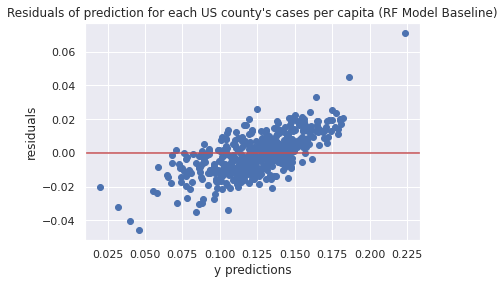

In [33]:
predictions = baseline_better.predict(X_test)
plt.scatter(predictions, y_test - predictions)
plt.ylabel('residuals')
plt.xlabel('y predictions')
plt.title("Residuals of prediction for each US county's cases per capita (RF Model Baseline)")
plt.axhline(y = 0, color='r');

In [50]:
baseline_better.score(X_test, y_test)

0.8860004944194824

In [51]:
score_test = baseline_better.score(X_test, y_test)
score_train = baseline_better.score(X_train, y_train)
print("Train Score is :", score_train)
print("Test Score is :", score_test)

Train Score is : 0.891453339556849
Test Score is : 0.8860004944194824


_The Random Forest Regression model (baseline) performed best, so we decided to improve upon the Random Forest Regression baseline model. 
The scatterplot 'Cases per Capita predicted vs Cases per Capita actual for RF Model Baseline' in comparison to the scatterplot 'Cases per Capita predicted vs Cases per Capita actual for LR Model Baseline' clearly shows that the RF model is a much better fit as there is a stronger linear relationship between the y_predicted and the actual y in comparison to the Linear Regression model. Additionally, the train score R^2 value was 0.891 and test score R^2 was 0.886 for the RF model, while the LR model had a much lower train R^2 score of 0.141 and lower test R^2 score of 0.134. The train RMSE and test RMSE were both also much lower (0.011795235855206662, 0.011255643168113673) in comparison to (0.0324670825406989 and 0.03388256235809448). The higher R^2 scores and lower RMSE values shows the the RF model fit better to our data._


In [21]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(baseline_better.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(15)

,importance
feature,
prop_vac,0.170
ALWAYS,0.166
SOMETIMES,0.100
NEVER,0.086
RARELY,0.081
FREQUENTLY,0.080
retail_and_recreation_percent_change_from_baseline,0.077
workplaces_percent_change_from_baseline,0.075
grocery_and_pharmacy_percent_change_from_baseline,0.067


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6b

Improve your model from part (a). Specify the supervised model you choose and write $f(x)$ as a function of the chosen features and parameters in your model. Justify why you chose these features and how you expect they will correlate with the output you wish to predict.

<!--
BEGIN QUESTION
name: q6b
points: 0
manual: True
-->

### FINDING WAYS TO IMPROVE MODEL - FIRST TRY - FEATURE SELECTION / CROSS VALIDATION

In [27]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error


def compute_CV_error(model, X_train, Y_train):
    kf = KFold(n_splits=10)
    validation_errors = []

    for train_idx, valid_idx in kf.split(X_train):
        # split the data
        split_X_train, split_X_valid = X_train.iloc[train_idx,:], X_train.iloc[valid_idx,:]
        split_Y_train, split_Y_valid = Y_train.iloc[train_idx], Y_train.iloc[valid_idx]

        # Fit the model on the training split
        model.fit(split_X_train, split_Y_train)
        
        # Compute the RMSE on the validation split
        error = rmse(split_Y_valid, model.predict(split_X_valid))


        validation_errors.append(error)
        
    return np.mean(validation_errors)

In [28]:
compute_CV_error(RandomForestRegressor(), X_train, y_train)

0.03152603415580695

In [29]:
errors = []
for N in np.arange(1,12):
    print(f"Trying first {N} features")

    # compute the cross validation error
    error = compute_CV_error(RandomForestRegressor(), X_train.iloc[:, :N], y_train)
    
    print("\tRMSE:", error)
    errors.append(error)

best_num_features = np.argmin(errors) + 1
best_err = min(errors)
print(f"Best choice, use the first {best_num_features} features")

Trying first 1 features
	RMSE: 0.04015896428694099
Trying first 2 features
	RMSE: 0.03700889461812737
Trying first 3 features
	RMSE: 0.03596695094000228
Trying first 4 features
	RMSE: 0.035360005795992945
Trying first 5 features
	RMSE: 0.03532486639457322
Trying first 6 features
	RMSE: 0.034406407795098896
Trying first 7 features
	RMSE: 0.03303803529356388
Trying first 8 features
	RMSE: 0.03242175115741901
Trying first 9 features
	RMSE: 0.0316912233983354
Trying first 10 features
	RMSE: 0.031556072595192275
Trying first 11 features
	RMSE: 0.0313372137401589
Best choice, use the first 11 features


_Cross-validation errors show that all of the features should be used to optimize the model._

### IMPROVEMENT 1

_Changes to inputs:_
- "rate_of_vaccination" (replaces ‘prop_vac’) - represents the percent increase of fully vaccinated individuals starting from 07/02/2021 to 07/14/2021. (percentage is the number of fully vaccinated individuals each day divided by the total number of vaccinated (by 9/12/21)). 
- New feature: 'rate_cases_per_capita' -  the daily increase of cases (from 07/02/2021 to 07/14/2020) divided by the population estimate for each county (POPESTIMATE2020). 
- New feature: ‘residential_percent_change_from_baseline' - can take the raw social mobility scores for each day in the specified time frame (07/02/2021 to 07/14/2020), so there are more data points that are not null. Therefore, we can use this feature, and fill any NAN values with 0. 

- All of the mask use features outlined in the baseline model are still used.
- All of the social mobility features outlined in the baseline model, but instead of taking the median, we take the raw social mobility score because we are deriving values for each day in the time frame. 

_Additional Notes:_
- We used the time frame from 07/02/2021 to 07/14/2021, because the data regarding mask usage is also taken from this time frame.

_Outputs:_
- same as baseline model: (‘cases_per_capita’ determined by taking the total number of cases recorded by 09/12/21 and dividing it by POPESTIMATE2020 for each county.)


_Problem: Our baseline model performed quite well, but one improvement would be introducing more data. You can see in the scatterplot "Residuals of prediction for each US county's cases per capita (RF Model Baseline)" that the residual values are increasing for points that are at the lower and higher ends of the output value (cases per capita). This means that the model needs improvement in predicting for points that are outliers or for data points represented less in the data._

_Solution: We are trying to predict total cases per capita for each county (updated until 9/12/21), so it would be beneficial to add a time component to our features. The accuracy of our model will increase as more data is introduced for each county, because Random Forest Regressor will be able to interpret and include more complex relationships between our features and the output variable. We collected data on our features from the time frame from 07/02/21 to 07/14/21. The changes we made in comparison to the baseline model was that we added two features, and updated what values we would use for social mobility scores. Instead of using the proportion fully vaccinated (‘prop_vac’), we replaced it with a ‘rate_of_vaccination’ value that represents the percent of fully vaccinated people in each county daily. We also created a feature called ‘rate_cases_per_capita” which represents the daily increase of cases per capita for each county. Instead of using the median of social mobility scores overtime, we selected the raw values from each day instead._


In [34]:
##rate of increase for cases per capita
cd = county_data.copy()
cd = cd.set_index('FIPS')
cd = cd.iloc[:,536:548].diff(axis = 1).div(cd["POPESTIMATE2020"], axis=0)
cases_rate = cd.stack().reset_index()
cases_rate = cases_rate.rename(columns = {'level_1':'Date',0:'rate_cases_per_capita'})
cases_rate['FIPS'] = cases_rate['FIPS'].astype(int)
cases_rate['Date'] = pd.to_datetime(cases_rate['Date'])
cases_rate

,FIPS,Date,rate_cases_per_capita
0,1001,2021-07-02,0.000089
1,1001,2021-07-03,0.000000
2,1001,2021-07-04,0.000000
3,1001,2021-07-05,0.000000
4,1001,2021-07-06,0.000000
...,...,...,...
34546,56045,2021-07-08,0.000000
34547,56045,2021-07-09,0.000148
34548,56045,2021-07-10,0.000000
34549,56045,2021-07-11,0.000000


In [93]:
cases_rate.groupby('FIPS').mean()

,rate_cases_per_capita
FIPS,
1001,0.000079
1003,0.000123
1005,0.000078
1007,0.000045
1009,0.000060
...,...
56037,0.000156
56039,0.000089
56041,0.000040


In [35]:
# rates_vaccines = pd.read_csv('vaccines_counties_time.csv')
# rates_vaccines['Date'] = pd.to_datetime(rates_vaccines['Date'])  
# rates_vaccines = rates_vaccines.loc[(rates_vaccines['Date'] >= '2021-07-01') & (rates_vaccines['Date'] <= '2021-07-14')]
# new_vac = rates_vaccines.set_index('Date').pct_change() #diff(axis = 0) # percent derived from total vaccinated (9/12/21)
# new_vac = new_vac.T.stack().reset_index()
# new_vac = new_vac.rename(columns = {'level_0':'FIPS',0:'rate_of_vaccination'})
# new_vac['FIPS'] = new_vac['FIPS'].astype(int)
# new_vac

,FIPS,Date,rate_of_vaccination
0,1001,2021-07-02,0.000000
1,1001,2021-07-03,0.003164
2,1001,2021-07-04,0.000000
3,1001,2021-07-05,0.003538
4,1001,2021-07-06,0.000000
...,...,...,...
38345,78030,2021-07-10,0.000839
38346,78030,2021-07-11,0.000000
38347,78030,2021-07-12,0.001258
38348,78030,2021-07-13,0.003489


In [95]:
new_vac.groupby('FIPS').mean() # mean rate of vaccination for days between 07/02 to 07/14

,rate_of_vaccination
FIPS,
1001,0.001787
1003,0.001767
1005,0.006680
1007,0.001935
1009,0.001536
...,...
72151,0.008569
72153,0.004738
78010,0.002310


In [36]:
# dated_sm = pd.read_csv('social_mobility_july.csv')
# dated_sm['sub_region_2'] = dated_sm['sub_region_2'].str.replace(' County', '')
# newer = county_data.reset_index().merge(dated_sm, left_on = ['Province_State','Admin2'], right_on = ['sub_region_1','sub_region_2'])
# newer['FIPS'] = newer['FIPS'].astype(int)
# newer = newer[['FIPS','date', 'retail_and_recreation_percent_change_from_baseline',
#             'grocery_and_pharmacy_percent_change_from_baseline','parks_percent_change_from_baseline', 
#             'transit_stations_percent_change_from_baseline','workplaces_percent_change_from_baseline', 
#             'residential_percent_change_from_baseline']].rename(columns = {'date':'Date'})
# newer['Date'] = pd.to_datetime(newer['Date'])  
# print(len(newer))
# newer.isnull().sum().sort_values()
# lots of null values fill with 0 for now

27053


FIPS                                                      0
Date                                                      0
workplaces_percent_change_from_baseline                 414
retail_and_recreation_percent_change_from_baseline    10281
residential_percent_change_from_baseline              11547
grocery_and_pharmacy_percent_change_from_baseline     12440
transit_stations_percent_change_from_baseline         17342
parks_percent_change_from_baseline                    21364
dtype: int64

In [37]:
almost = cases_rate.merge(newer, left_on = ['FIPS','Date'], right_on = ['FIPS','Date']) #newer.fillna(0)
final = almost.merge(new_vac, left_on = ['FIPS','Date'], right_on=['FIPS', 'Date'])
final = final.merge(placer, left_on = 'FIPS', right_on = 'FIPS')
#final['Date'] = final['Date'].astype(int)

### After First Improvement

In [104]:
# from sklearn.ensemble import RandomForestRegressor
# final = final.fillna(0)
# X = final[["rate_of_vaccination",'rate_cases_per_capita',
#            'workplaces_percent_change_from_baseline',
#            'retail_and_recreation_percent_change_from_baseline', 'residential_percent_change_from_baseline',
#             'grocery_and_pharmacy_percent_change_from_baseline','parks_percent_change_from_baseline', 
#             'transit_stations_percent_change_from_baseline',
#             'NEVER','ALWAYS', 'SOMETIMES','FREQUENTLY', 'RARELY']]
# y = final['cases_per_capita']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# baseline = RandomForestRegressor()
# baseline.fit(X, y)

# def rmse(predicted, actual):
#     return np.sqrt(np.mean((actual - predicted)**2))

# train_rmse = rmse(baseline.predict(X_train), y_train)
# test_rmse = rmse(baseline.predict(X_test), y_test)

# train_rmse, test_rmse

(0.002120425806614615, 0.002121575606160645)

Text(0.5, 1.0, 'Cases per Capita predicted vs Cases per Capita actual for RF Model Improved 1')

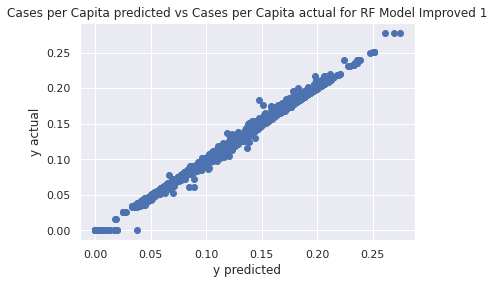

In [105]:
plt.scatter(baseline.predict(X_test), y_test)
plt.xlabel('y predicted')
plt.ylabel('y actual')
plt.title('Cases per Capita predicted vs Cases per Capita actual for RF Model Improved 1')

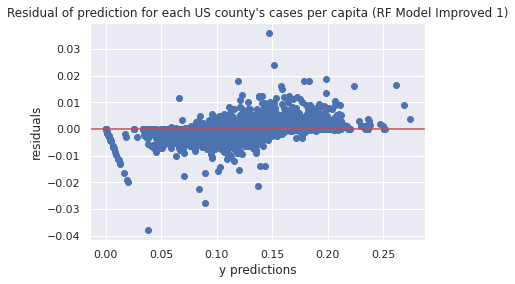

In [106]:
predictions = baseline.predict(X_test)
plt.scatter(predictions, y_test - predictions)
plt.ylabel('residuals')
plt.xlabel('y predictions')
plt.title("Residual of prediction for each US county's cases per capita (RF Model Improved 1)")
plt.axhline(y = 0, color='r');

In [107]:
baseline.score(X_test, y_test)

0.9963166978050538

In [108]:
score_test = baseline.score(X_test, y_test)
score_train = baseline.score(X_train, y_train)
print("Train Score is :", score_train)
print("Test Score is :", score_test)

Train Score is : 0.9962266001619805
Test Score is : 0.9963166978050538


Result: Our intuition was correct, and the model improved. 

_Takeaways from the plots and statistics shown above:_
- In the plot 'Cases per Capita predicted vs Cases per Capita actual for RF Model Improved 1', you can see that the linear relationship became stronger. The overall coefficient of determination increased (from ~.89 in the baseline model to ~.99 in the improved model). 
- The residuals for points at the higher ends of the output values (y predictions) also decreased by ~.02, which is quite a large quantity considering our output values are scaled to be from 0.00 to 0.25. 
- The training and test RMSE also decreased by more than half of the baseline model’s value (from ~.01 to ~.002 for both training and test RMSE).

In [109]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(baseline.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(15)

,importance
feature,
ALWAYS,0.283
RARELY,0.147
NEVER,0.145
SOMETIMES,0.142
FREQUENTLY,0.130
retail_and_recreation_percent_change_from_baseline,0.036
transit_stations_percent_change_from_baseline,0.033
parks_percent_change_from_baseline,0.027
grocery_and_pharmacy_percent_change_from_baseline,0.020


_This table's column 'importance' measures the decrease in node impurity weighted by the probability of reaching that node. The higher this value is for each feature, the more important the feature is considered in improving the model's accuracy and reducing model variance._

### SECOND IMPROVEMENT - FEATURE ENGINEERING - 'transit_stations_percent_change_from_baseline' and 'parks_percent_change_from_baseline'

_Inputs:_
- same as the improved model above, but we applied feature engineering to the features: 'transit_station_percent_change_from_baseline' and 'parks_percent_change_from_baseline' in order to fill the null values existing in these features. 

_Outputs:_
- same as baseline model: (‘cases_per_capita’ determined by taking the total number of cases recorded by 09/12/21 and dividing it by POPESTIMATE2020 for each county.)

_Problem: More than half of the values in the dataset had null values for the features: ‘parks_percent_change_from_baseline’ (21364/27053) and ‘transit_stations_percent_change_from_baseline’ (17342/27053). These features for social mobility are not as efficient in the model, because they all will be replaced with 0. We should  make these features more meaningful, and the Random Forest Regression model will be able to add more layers of complexity in terms of relationships between features and the output which might increase the accuracy rate of predictions._


_Solution: We filled these null values in the two features listed above with predictions determined from a Random Forest Regression model in order to make full use of these features, add more layers of complexity to our model, and potentially lower variance._

In [38]:
# almost = cases_rate.merge(newer, left_on = ['FIPS','Date'], right_on = ['FIPS','Date']) #newer.fillna(0)
# final = almost.merge(new_vac, left_on = ['FIPS','Date'], right_on=['FIPS', 'Date'])
# final = final.merge(placer, left_on = 'FIPS', right_on = 'FIPS')

<AxesSubplot:>

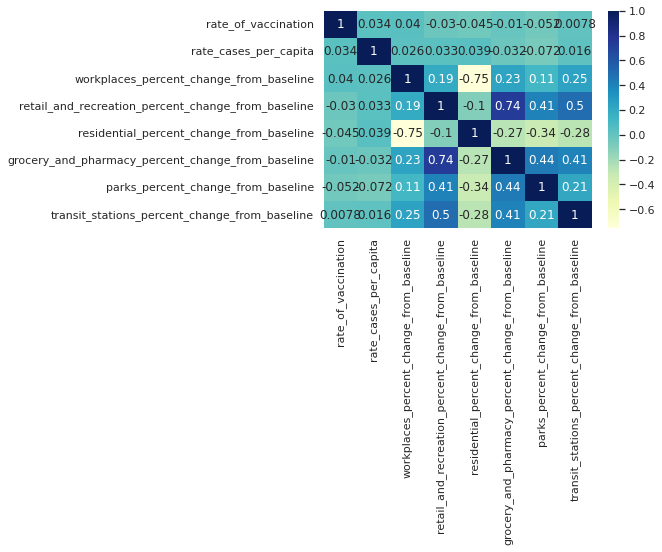

In [39]:
sb.heatmap(final[["rate_of_vaccination",'rate_cases_per_capita',
           'workplaces_percent_change_from_baseline',
           'retail_and_recreation_percent_change_from_baseline', 'residential_percent_change_from_baseline',
            'grocery_and_pharmacy_percent_change_from_baseline','parks_percent_change_from_baseline', 
            'transit_stations_percent_change_from_baseline']].corr(), cmap="YlGnBu", annot=True)

<AxesSubplot:>

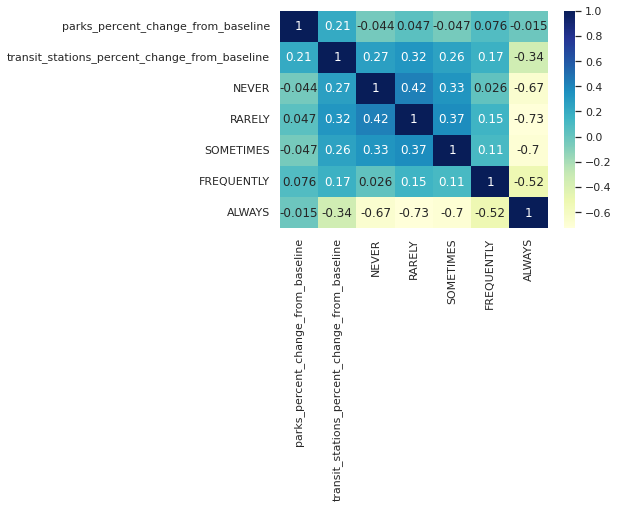

In [41]:
sb.heatmap(final[['parks_percent_change_from_baseline', 
            'transit_stations_percent_change_from_baseline',"NEVER","RARELY","SOMETIMES","FREQUENTLY","ALWAYS"]].corr(), cmap="YlGnBu", annot=True)

_Inputs_:
- 'rate_of_vaccination'
- 'rate_cases_per_capita'
- 'grocery_and_pharmacy_percent_change_from_baseline'
- 'retail_and_recreation_percent_change_from_baseline'
- 'transit_stations_percent_change_from_baseline'
- 'workplaces_percent_change_from_baseline'
- 'residential_percent_change_from_baseline'
- "NEVER"
- "RARELY"
- "SOMETIMES"
- "FREQUENTLY"
- "ALWAYS"

_All of the inputs are ones taken from the improved model above._

_The inputs were chosen based on the above correlation matrices. These matrices show that there is a varying range of linear correlations with the inputs we chose and our output which is 'park_percent_change_from_baseline'. It ranges from a correlation of -.044 to .44. Since some features do not have a very strong linear correlation while some features have a moderate linear correlation, we will use a Random Forest Regression model to make a prediction about the values in our dataframe that are null for the 'park_percent_change_from_baseline' value._

### Feature Engineering Parks

In [40]:
#finding all rows with null values for 'parks' social mobility score
# parks = final.copy()
# null_vals_parks = parks[parks['parks_percent_change_from_baseline'].isnull()]
# x_parks = np.array(null_vals_parks[['rate_of_vaccination', 'rate_cases_per_capita', 'retail_and_recreation_percent_change_from_baseline',
#             'grocery_and_pharmacy_percent_change_from_baseline', 
#             'transit_stations_percent_change_from_baseline','workplaces_percent_change_from_baseline',
#                                     'residential_percent_change_from_baseline',
#           "NEVER","RARELY","SOMETIMES","FREQUENTLY","ALWAYS"]].fillna(0))

In [112]:
# fin = final.copy()
# fin = fin.fillna(0)
# X = fin[['rate_of_vaccination', 'rate_cases_per_capita',
#             'grocery_and_pharmacy_percent_change_from_baseline', 'retail_and_recreation_percent_change_from_baseline',
#             'transit_stations_percent_change_from_baseline','workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline',
#           "NEVER","RARELY","SOMETIMES","FREQUENTLY","ALWAYS"]]
# y = fin['parks_percent_change_from_baseline']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# baseline = RandomForestRegressor()
# baseline.fit(X, y)

# def rmse(predicted, actual):
#     return np.sqrt(np.mean((actual - predicted)**2))

# train_rmse = rmse(baseline.predict(X_train), y_train)
# test_rmse = rmse(baseline.predict(X_test), y_test)

# train_rmse, test_rmse

(12.08099803978365, 12.164158540756375)

In [113]:
y_pred_parks = baseline.predict(x_parks)

null_vals_parks = parks['parks_percent_change_from_baseline'].isnull()
final.loc[null_vals_parks, 'parks_percent_change_from_baseline'] = y_pred_parks

Text(0.5, 1.0, 'Parks social mobility score predicted vs Parks social mobility score actual')

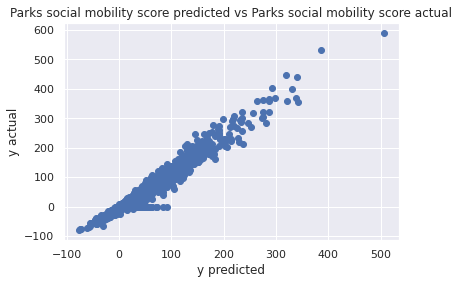

In [114]:
plt.scatter(baseline.predict(X_test), y_test)
plt.xlabel('y predicted')
plt.ylabel('y actual')
plt.title('Parks social mobility score predicted vs Parks social mobility score actual')

In [73]:
baseline.score(X_test, y_test)

0.9411360562121968

_This model is determined to be good enough to predict the social mobility scores for 'parks_percent_change_from_baseline' as it has a R^2 value of around .941._

### Feature Engineering Transit

_Inputs_:
- 'rate_of_vaccination'
- 'rate_cases_per_capita'
- 'grocery_and_pharmacy_percent_change_from_baseline'
- 'retail_and_recreation_percent_change_from_baseline'
- 'parks_percent_change_from_baseline'
- 'workplaces_percent_change_from_baseline'
- 'residential_percent_change_from_baseline'
- "NEVER"
- "RARELY"
- "SOMETIMES"
- "FREQUENTLY"
- "ALWAYS"

_All of the inputs are ones taken from the improved model above._

_The inputs were chosen based on the above correlation matrices. These matrices show that there is a varying range of linear correlations with the inputs we chose and our output which is 'transit_stations_percent_change_from_baseline'. It ranges from a correlation of -.0078 to .41. Since some features do not have a very strong linear correlation while some features have a moderate linear correlation, we will use a Random Forest Regression model to make a prediction about the values in our dataframe that are null for the 'transit_stations_percent_change_from_baseline' value._

In [115]:
# transit = final.copy()
# null_vals_transit = transit[transit['transit_stations_percent_change_from_baseline'].isnull()]
# x_transit = np.array(null_vals_transit[['rate_of_vaccination', 'rate_cases_per_capita',
#                                         'residential_percent_change_from_baseline',
#             'grocery_and_pharmacy_percent_change_from_baseline','parks_percent_change_from_baseline',
#              'retail_and_recreation_percent_change_from_baseline', 'workplaces_percent_change_from_baseline',
#             "NEVER","RARELY","SOMETIMES","FREQUENTLY","ALWAYS"]].fillna(0))

In [116]:
# fin = final.copy()
# fin = fin.fillna(0)
# X = fin[['rate_of_vaccination','rate_cases_per_capita',
#             'grocery_and_pharmacy_percent_change_from_baseline','parks_percent_change_from_baseline', 
#             'workplaces_percent_change_from_baseline','residential_percent_change_from_baseline',
#            'retail_and_recreation_percent_change_from_baseline',
#           "NEVER","RARELY","SOMETIMES","FREQUENTLY","ALWAYS"]]
# y = fin['transit_stations_percent_change_from_baseline']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# baseline = RandomForestRegressor()
# baseline.fit(X, y)

# def rmse(predicted, actual):
#     return np.sqrt(np.mean((actual - predicted)**2))

# train_rmse = rmse(baseline.predict(X_train), y_train)
# test_rmse = rmse(baseline.predict(X_test), y_test)

# train_rmse, test_rmse

(5.767774149371768, 5.841809434364862)

Text(0.5, 1.0, 'Transit social mobility score predicted vs Transit social mobility score actual')

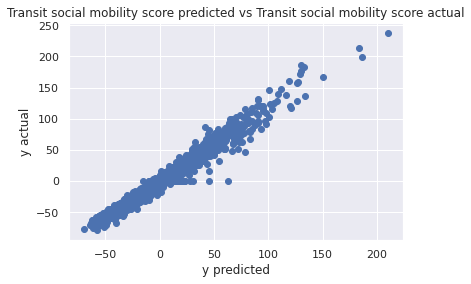

In [117]:
plt.scatter(baseline.predict(X_test), y_test)
plt.xlabel('y predicted')
plt.ylabel('y actual')
plt.title('Transit social mobility score predicted vs Transit social mobility score actual')

In [118]:
baseline.score(X_test, y_test)

0.9441877933315731

_This model is determined to be good enough to predict the social mobility scores for 'transit_stations_percent_change_from_baseline' as it has a R^2 value of around .944._

In [78]:
# y_pred_transit = baseline.predict(x_transit)

# null_vals_transit = transit['transit_stations_percent_change_from_baseline'].isnull()
# final.loc[null_vals_transit, 'transit_stations_percent_change_from_baseline'] = y_pred_transit

### FINAL MODEL AND EVALUATION

In [79]:
# from sklearn.ensemble import RandomForestRegressor
# final = final.fillna(0)
# X = final[["rate_of_vaccination",'rate_cases_per_capita',
#            'workplaces_percent_change_from_baseline',
#            'retail_and_recreation_percent_change_from_baseline', 'residential_percent_change_from_baseline',
#             'grocery_and_pharmacy_percent_change_from_baseline','parks_percent_change_from_baseline', 
#             'transit_stations_percent_change_from_baseline',
#             'NEVER','ALWAYS', 'SOMETIMES','FREQUENTLY', 'RARELY']]
# y = final['cases_per_capita']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# baseline = RandomForestRegressor()
# baseline.fit(X, y)

# def rmse(predicted, actual):
#     return np.sqrt(np.mean((actual - predicted)**2))

# train_rmse = rmse(baseline.predict(X_train), y_train)
# test_rmse = rmse(baseline.predict(X_test), y_test)

# train_rmse, test_rmse

(0.0024452706222808152, 0.002176856467826995)

In [152]:
errors = []
for N in np.arange(1,14):
    print(f"Trying first {N} features")

    # compute the cross validation error
    error = compute_CV_error(RandomForestRegressor(), X_train.iloc[:, :N], y_train)
    
    print("\tRMSE:", error)
    errors.append(error)

best_num_features = np.argmin(errors) + 1
best_err = min(errors)
print(f"Best choice, use the first {best_num_features} features")

Trying first 1 features
	RMSE: 0.04023079827295893
Trying first 2 features
	RMSE: 0.038194488390326985
Trying first 3 features
	RMSE: 0.03600658809284159
Trying first 4 features
	RMSE: 0.034954274101133345
Trying first 5 features
	RMSE: 0.03392486483964276
Trying first 6 features
	RMSE: 0.033587447209131524
Trying first 7 features
	RMSE: 0.03272816763172469
Trying first 8 features
	RMSE: 0.031506289716131806
Trying first 9 features
	RMSE: 0.026179473156886623
Trying first 10 features
	RMSE: 0.019615156503424377
Trying first 11 features
	RMSE: 0.01397822694189905
Trying first 12 features
	RMSE: 0.011150313403513813
Trying first 13 features
	RMSE: 0.009599774536970277
Best choice, use the first 13 features


Text(0.5, 1.0, 'Cases per Capita predicted vs Cases per Capita actual for RF Model Improved Final')

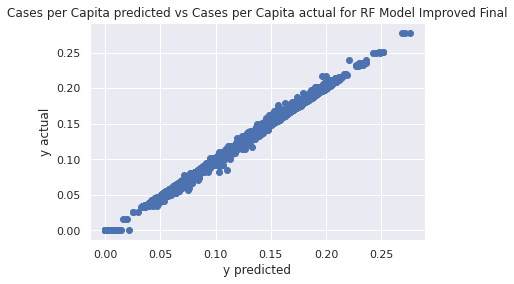

In [80]:
plt.scatter(baseline.predict(X_test), y_test)
plt.xlabel('y predicted')
plt.ylabel('y actual')
plt.title('Cases per Capita predicted vs Cases per Capita actual for RF Model Improved Final')

_Takeaway: There is a strong positive correlation between cases per capita predicted and the actual cases per capita for each county after training our final RF model with both of our improvements. This means our R^2 value is most likely very high meaning our model has fit to our data very will. The predictions are very accurate to the actual cases per capita value for most points._

_Connection to project: In comparison to the scatterplot 'Cases per Capita predicted vs Cases per Capita actual for RF Model Improved 1', this scatterplot shows a slight decrease in distance of the y predicted value to the y actual value. This essentially means that the residuals have gotten smaller for certain points in this final model in comparison to the previous model._

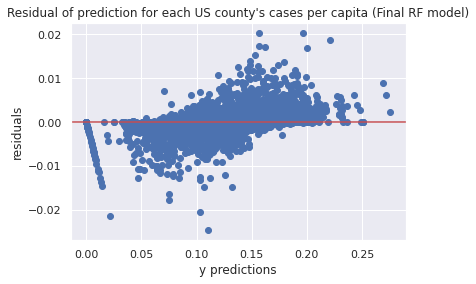

In [81]:
predictions = baseline.predict(X_test)
plt.scatter(predictions, y_test - predictions)
plt.ylabel('residuals')
plt.xlabel('y predictions')
plt.title("Residual of prediction for each US county's cases per capita (Final RF model)")
plt.axhline(y = 0, color='r');

_Takeaway: The residuals are low for our y predictions in this final model meaning our predictions are close to the actual values of each county's cases per capita._

_Connection to project: The residuals have decreased for the data in the lower range of our output (cases per capita) meaning our model has gotten more accurate at predicting cases per capita for counties that have a low cases per capita value (0.00 to 0.05)._

In [82]:
baseline.score(X_test, y_test)

0.9960049564451132

In [306]:
compute_CV_error(RandomForestRegressor(), X_train, y_train)

0.013843310748833791

In [83]:
score_test = baseline.score(X_test, y_test)
score_train = baseline.score(X_train, y_train)
print("Train Score is :", score_train)
print("Test Score is :", score_test)

Train Score is : 0.995055285798306
Test Score is : 0.9960049564451132


_Result:_ 
- In the plot 'Cases per Capita predicted vs Cases per Capita actual for RF Model Improved Final', you can see that the linear relationship stayed mostly the same. Both the train R^2 and test R^2 values decreased slightly (by ~.001). The train R^2 went from 0.9962266001619805 to 0.995055285798306 and the test R^2 score went from 0.9963166978050538 to 0.9960049564451132. This change is too small for it to be a drastic reduction in the model's performance, but it can still be considered a slight decrease in our model's performance.  
- The residuals for points at the higher and lower ends of the output values (y predictions) also decreased more in comparison to the model after the first improvement (by ~.02 for the lower end of the output values and by ~.01 for the upper ends of the output values). The range of values for our residuals decreased, which can be considered an improvement to our model.  
- The training RMSE increased slightly (by ~.0003) and the test RMSE increased even more slightly (by ~.00001). (from (0.002120425806614615, 0.002121575606160645) to (0.0024452706222808152, 0.002176856467826995)). This can be seen as a very slight decrease in our model's performance.

_A possibility as to why this improvement did not overall help in improving the model by much but instead slightly hindered its performance could be due to the fact that when model complexity increases, model variance also increases. The dataset might have gotten noisier which can in turn cause the model to capture this noisy data overall resulting in overfitting. Our improvement added more complexity to our model by making two of our features more representative of each county instead of just being 0 for most data points, but this in turn can make too complex of a model especially when using decision trees and many features in our Random Forest Regression model. Overfitting will overall decrease the accuracy of our model hence why our R^2 value was slightly lower and our RMSE values slightly higher._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6c

If applicable, write an equation or rule for the prediction function $f(x)$; if this is infeasible, make sure to visualize your model parameters in some way. Interpret your improved model's optimal parameters (*hint*: refer to 1aiii), and compare these parameters to those of the baseline model. Comment on whether the parameters follow physical intuition given the nature of the prediction task.

For example, if you chose to use a decision tree, you may interpret the generated rules.
 
<!--
BEGIN QUESTION
name: q6c
points: 0
manual: True
-->

In [85]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(baseline.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(15)

,importance
feature,
ALWAYS,0.280
RARELY,0.146
NEVER,0.141
SOMETIMES,0.135
FREQUENTLY,0.125
transit_stations_percent_change_from_baseline,0.038
parks_percent_change_from_baseline,0.037
retail_and_recreation_percent_change_from_baseline,0.036
grocery_and_pharmacy_percent_change_from_baseline,0.021


In [83]:
# #printing out decision trees is too large to interpret
# estimator = baseline.estimators_[0]
# from sklearn.tree import export_graphviz

# export_graphviz(estimator, out_file='tree.dot', 
#                 feature_names = X.columns,
#                 class_names = y.name,
#                 rounded = True, proportion = False, 
#                 precision = 2, filled = True)

# call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# from IPython.display import Image
# Image(filename = 'tree.png')

_The importance ranking of our final model's features are interesting. One thing to note is that after doing our second improvement to the model, you can see that the importance of the features: 'transit_stations_percent_change_from_baseline' and 'parks_percent_change_from_baseline' slightly increased. This can be due to the fact that the predictions we made were quite accurate and this helped the model to determine cases per capita more accurately. The importance of the features for mask usage became higher after improving the model in comparison to the baseline model. In addition, since we removed 'prop_vac' as a feature, 'ALWAYS' became a more important feature overall. The social mobility scores overall became weighted less important in comparison to the baseline model which could be beneficial to the overall model, because it seems like it contains noisier values._

### Future Work

_Future work could look more into safety precautions and how to slow down COVID-19 cases so that in the case of something like this happening again, we will have a better idea on how to handle the situation and have statistics to back it up. For example, we are currently looking at how these precautions affect the number of cases per capita for each county. We could dig deeper by looking at the rates of change for precautions like mask usage. This way, we would be able to see even more how correlated these precautions are with slowing down the spread of COVID-19. If some of these precautions correlate with a greater rate of change for a decrease in cases, we would know that this precaution is more effective. We would also visualize how having a combination of precautions could result in the greatest rate of change rather than just following one precaution. Furthermore, there are other precautions we could add to our model such as booster shots and surveillance testing. It would be interesting to see how these also affect cases per capita as well as the rates of change for cases for each county. Surveillance testing would be especially interesting, as surveillance testing would hopefully result in people being more cautious and being able to not spread the virus if they do have it by being able to know that they do have it. This could be correlated to lower social mobility scores as well. On the other hand, more testing may also just result in more cases as these cases are being detected. This is similar to other precautions as while precautions may intuitively result in fewer cases, more cases may also result in more precautions. Because of this, it would be interesting to model these variables and see how they interact upon one another so that we will be able to better understand how to prevent cases from increasing or spreading._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6d

Discuss your improved model's performance on both short-term and long-term time scales using a metric of your choice (*hint:* we're using an autoregressive model). In other words, given $x_t$, we wish to predict $\hat{x}_{t+k}$, and plot the error of these predictions for two $k$ values of your choice. You may use any reasonable interpretation of short-term and long-term predictions; an initial suggestion is to use 2-day predictions and 2-week predictions.

Compare the performance of this model on both timescales with the baseline model.

<!--
BEGIN QUESTION
name: q6d
points: 0
manual: True
-->

In [ ]:
...

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6e

Plot and describe the error for both the baseline and improved models as a function of time. In other words, given $x_t$, we wish to predict $\hat{x}_{t+k}$, and plot the error of these predictions for all $k$.

Consider how and why the performance of the model degrades as a function of time using the rate of growth in the error.

<!--
BEGIN QUESTION
name: q6e
points: 0
manual: True
-->

In [ ]:
...

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6f

Consider a modification to the model $f(x) = x_{t+1}$ where instead $f(x) = [x_{t+1}, x_{t+2}, ..., x_{t+m}]$ for some $m > 1$. In other words, using the features $x$ that contain past and present quantities, our model *explicitly* predicts values for $m$ days in the future rather than simply the next day (i.e. $m = 1$). 

Train the baseline and improved model using $m = 5$ and $m = 10$. Evaluate and visualize the predictive accuracy of both models.

<!--
BEGIN QUESTION
name: q6f
points: 0
manual: True
-->

In [ ]:
...

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [21]:
grader.check_all()

q1a results: All test cases passed!

q1d results: All test cases passed!

q1e results: All test cases passed!

q5b results: All test cases passed!

q5d results: All test cases passed!

q5f results: All test cases passed!

q5g results: All test cases passed!

q5i results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [63]:
# Save your notebook first, then run this cell to export your submission.
grader.export()